In [7]:
# import libraries
import numpy as np
import torch
import torch.nn as nn  # nn = neural network
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sys
sys.path.append("../myUtils")  # add parent directory to path to import myGraph

import myGraph
import text

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")  # set plot format to svg

# set dark style
plt.style.use("dark_background")

## FUNCTION: Create data (x, y)

In [8]:
def createData(a, b, N, noise=0, plot=False):
    x = torch.randn(N, 1)
    y = a*x + b + torch.randn(N, 1) * noise/100.0

    if plot:
        myGraph.showAxes(plt, grid=True)
        plt.plot(x, y, ".y")
        plt.show()

    return x, y  # return x and y as tensors


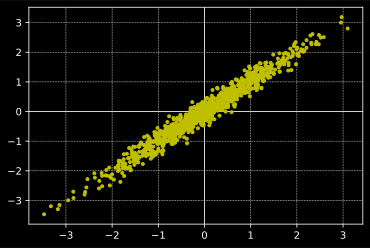

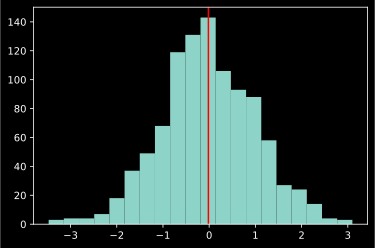

In [9]:
x, y = createData(1, 0, 1000, plot=True, noise=20)

# plot a histogram of x showing the distribution of values and the mean. Use 10 bins.
plt.close()
plt.hist(x.numpy(), bins=20)
plt.axvline(x.mean(), color="r")
plt.show()


## Train the model

In [10]:
## Train the model!
def train(x, y, *, maxEpochs=10000, loss_threshold=0.01, learningRate=0.01):
    epoch = 0
    losses = []  # Python list.
    weights = []  # Python list.

    # build model
    ANNreg = nn.Sequential(
        nn.Linear(1, 1),  # input layer: 1 input feature, 1 output feature, bias = True (default)
        nn.ReLU(),  # activation function
        nn.Linear(1, 1),  # hidden layer: 1 input feature, 1 output feature, bias = True (default)
    )

    lossfun = nn.MSELoss()  # mean squared error loss

    optimizer = torch.optim.SGD(ANNreg.parameters(), lr=learningRate)

    ## Train the model!
    while epoch < maxEpochs:
        # forward pass
        yHat = ANNreg(x)  # compute predictions given inputs x

        # compute loss
        loss = lossfun(
            yHat, y
        )  # compute loss given true y and predicted yHat (mean squared error loss)
        losses.append(loss.detach().numpy())  # NumPy array

        # backprop
        optimizer.zero_grad()  # zero out gradients (otherwise they are accumulated)
        loss.backward()  # compute gradients (backpropagation)
        optimizer.step()  # update parameters with gradients (gradient descent)

        weights.append(
            [ANNreg[0].weight.item(), ANNreg[0].bias.item()]
        )  # save weights and bias

        if loss < loss_threshold:
            break

        epoch += 1

    predictions = ANNreg(x).detach().numpy()  # compute predictions given inputs x

    return predictions, losses, weights, epoch

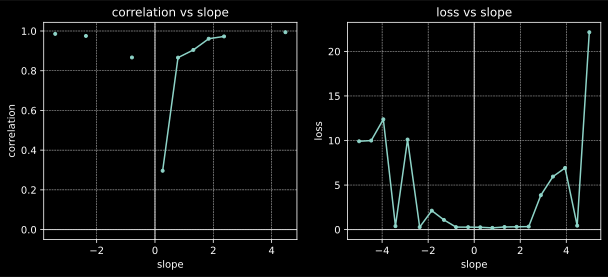

In [13]:
av_correlations = []
av_finalLosses = []

domain = np.linspace(-5, 5, 20)

for i in range(2):
    correlations = []
    finalLosses = []
    for m in domain:
        x, y = createData(m, 0, 50, noise=50, plot=False)
        predictions, losses, _, _ = train(x, y, maxEpochs=250, loss_threshold=0.01, learningRate=0.05)
        loss = losses[-1]
        finalLosses.append(loss)
        correlation = np.corrcoef(y.T, predictions.T)[0, 1]
        correlations.append(correlation)

    av_correlations.append(correlations)
    av_finalLosses.append(finalLosses)

av_correlations = np.array(av_correlations)
av_finalLosses = np.array(av_finalLosses)

correlations = np.mean(av_correlations, axis=0)

# Remove NaNs from correlations
# correlations = correlations[~np.isnan(correlations)]

finalLosses = np.mean(av_finalLosses, axis=0)


plt.close()

# plot loss and correlation vs slope
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

myGraph.showAxes(ax[0], grid=True)
myGraph.showAxes(ax[1], grid=True)

ax[0].plot(domain, correlations, ".-")
ax[0].set_xlabel("slope")
ax[0].set_ylabel("correlation")
ax[0].set_title("correlation vs slope")

ax[1].plot(domain, finalLosses, ".-")
ax[1].set_xlabel("slope")
ax[1].set_ylabel("loss")
ax[1].set_title("loss vs slope")

plt.show()



In [ ]:
min(correlations)

nan